In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from pyedflib import highlevel
import yasa
import glob
import ghibtools as gt
import mne
from params import *

## PARAMS

In [3]:
patient

'P17'

In [4]:
input_file = glob.glob(f'../data/{patient}/*.edf')[0]

In [5]:
save_da = False
save_df = False

## TOOLS

In [6]:
def eeg_mono_to_bipol(da, dérivations, bipol_eog = True):
    da_bipol = []
    for bipol in dérivations : 
        pole1, pole2 = bipol.split('-')[0] , bipol.split('-')[1]
        if pole1 in ['EOGDt','EOGG']:
            chan1 = pole1
        
            chan2 = f'EEG {pole2}'
        else:
            chan1 = f'EEG {pole1}'
            chan2 = f'EEG {pole2}'
        sig1 = da.loc[chan1,:]
        sig2 = da.loc[chan2,:]

        bipol_sig = sig1 - sig2
        da_bipol.append(bipol_sig)
    da_bipolaire = xr.concat(da_bipol, dim = 'chan')
    da_bipolaire = da_bipolaire.assign_coords({'chan':dérivations})
    return da_bipolaire

In [7]:
def to_notch_da(da, fs):
    chans = list(da.coords['chan'].values)
    da_notched = da.copy()
    for channel in chans:
        sig = da.sel(chan = channel).values
        sig_notched = gt.notch(sig, fs=fs)
        if channel == 'ECG':
            sig_notched = -sig_notched
        da_notched.loc[channel, :] = sig_notched
    return da_notched

In [8]:
def da_to_mne_object(da, srate):
    ch_names = list(da.coords['chan'].values)
    sfreq = srate
    info = mne.create_info(ch_names, sfreq, ch_types='misc', verbose=None)
    raw = mne.io.RawArray(data = da.values, info=info, first_samp=0, copy='auto', verbose=None)
    return raw

## LOAD RAW

In [9]:
signals, signal_headers, header = highlevel.read_edf(input_file)

In [10]:
header

{'technician': '',
 'recording_additional': '',
 'patientname': 'FONTANEL FANNY',
 'patient_additional': '',
 'patientcode': '',
 'equipment': 'Deltamed',
 'admincode': '180918D-B',
 'gender': 'Female',
 'startdate': datetime.datetime(2018, 9, 18, 20, 38, 7),
 'birthdate': '12 oct 1995',
 'annotations': [[171.875, -1.0, 'SATURATION DES VOIES : THERM'],
  [241.875, -1.0, 'SATURATION DES VOIES : ABD'],
  [671.875, -1.0, 'SATURATION DES VOIES : THERM'],
  [681.875, -1.0, 'SATURATION DES VOIES : THO'],
  [701.875, -1.0, 'SATURATION DES VOIES : THERM'],
  [3576.875, -1.0, 'SATURATION DES VOIES : ABD'],
  [3599.0, -1.0, 'Fin'],
  [3821.84375, -1.0, 'SATURATION DES VOIES : THERM'],
  [4981.84375, -1.0, 'SATURATION DES VOIES : ABD'],
  [5097.1875, -1.0, 'LumiÃ¨res Ã©teintes'],
  [5171.84375, -1.0, 'SATURATION DES VOIES : THERM'],
  [6261.84375, -1.0, 'SATURATION DES VOIES : ABD'],
  [6416.84375, -1.0, 'SATURATION DES VOIES : THERM'],
  [7199.0, -1.0, 'Fin'],
  [8086.8125, -1.0, 'SATURATION DES

In [11]:
srate = signal_headers[0]['sample_rate']
hp = float(signal_headers[0]['prefilter'].split(' ')[0].split('Hz')[0][-4:])
lp = float(signal_headers[0]['prefilter'].split(' ')[1].split('Hz')[0][-3:])
chans = [chan_dict['label'] for chan_dict in signal_headers]
eeg_chans = [ chan for chan in chans if 'EEG' in chan]
eeg_chans_clean = [ chan.split(' ')[1] for chan in chans if 'EEG' in chan]
eog_chans = [ chan for chan in chans if 'EOG' in chan] 
physio_chans = ['ECG','Menton','EOGDt','EOGG','DEBIT','THERM'] 
unit = signal_headers[0]['dimension']
time = np.arange(0 , signals.shape[1] / srate , 1 / srate)
dérivations = ['Fp2-C4' , 'C4-T4', 'T4-O2' , 'Fz-Cz' , 'Cz-Pz' , 'Fp1-C3', 'C3-T3', 'T3-O1', 'EOGDt-A1', 'EOGG-A2']
duration = round(time[-1], 2)
print(f'Srate : {srate}')
print(f'Total duration : {int(duration)} seconds')
print(f'Nb of eeg electrodes : {len(eeg_chans)}')
print(f'Nb physios electrodes : {len(physio_chans)}')

Srate : 256.0
Total duration : 39365 seconds
Nb of eeg electrodes : 13
Nb physios electrodes : 6


In [12]:
metadata = pd.Series([patient, srate , hp , lp , unit , len(eeg_chans), len(physio_chans), duration , round((duration / 60),2) , round((duration / 3600) , 2)], index = ['participant','srate','HP','LP','unit','n eeg chans','n extra eeg chans','sec duration','min duration','hour duration']).to_frame().T
metadata

,participant,srate,HP,LP,unit,n eeg chans,n extra eeg chans,sec duration,min duration,hour duration
0,P17,256.0,0.17,100.0,uV,13,6,39365.0,656.08,10.93


In [13]:
if save_df:
    metadata.to_excel(f'../participant_characteristics/metadata_{patient}.xlsx')

## PUT RAW IN DA

In [14]:
da = xr.DataArray(data = signals, dims = ['chan','time'] , coords = {'chan':chans , 'time':time})

## DISPLAY MONOPOLAR

* raw signals

<Figure size 640x480 with 0 Axes>

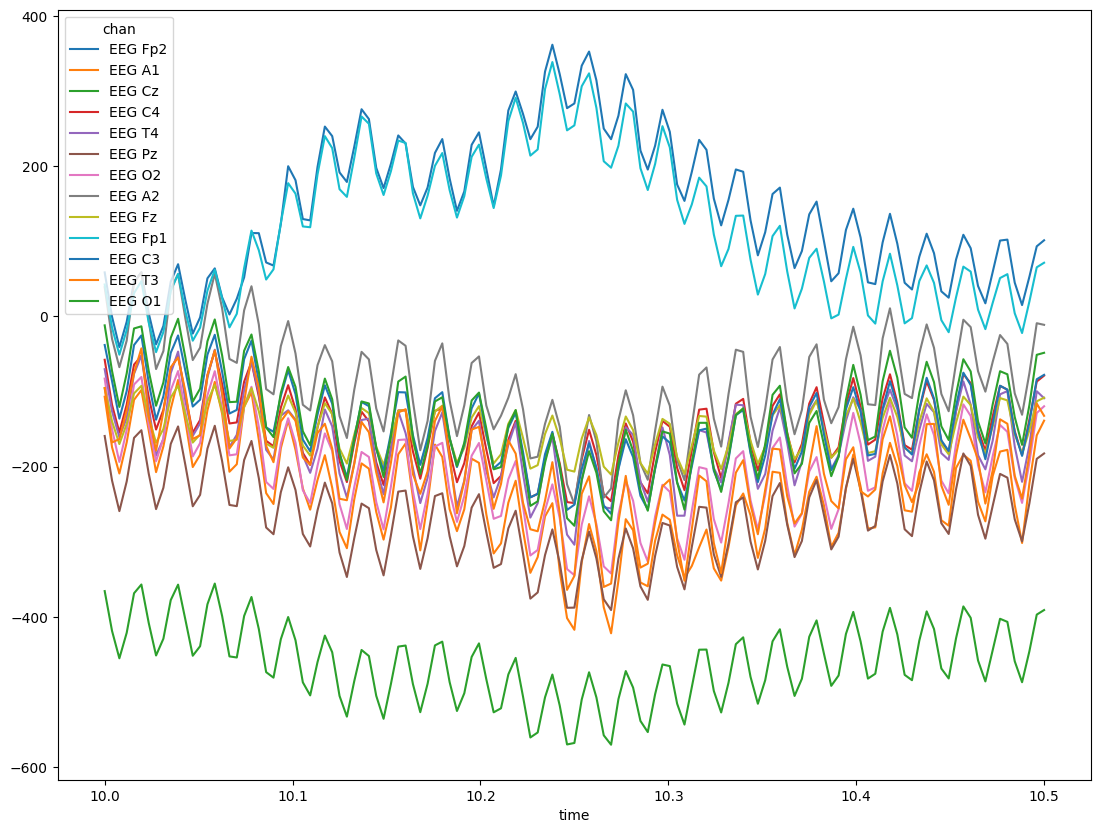

In [15]:
plt.figure()
da.loc[eeg_chans, 10:10.5].plot.line(x='time', hue = 'chan', size = 10)
# plt.savefig(f'../presentation/raw_signals_{patient}')
plt.show()

* psd of raw signals

In [16]:
# plt.figure()
# for chan in eeg_chans :
#     f, Pxx = gt.spectre(da.loc[chan,:].values, srate=srate, wsize = 50)
#     plt.plot(f, Pxx)

# # plt.savefig(f'../presentation/psd_raw_mono_{patient}')
# plt.show()

## MONO TO BIPOLAR 

* signals

In [17]:
da_bipol = eeg_mono_to_bipol(da, dérivations = dérivations)

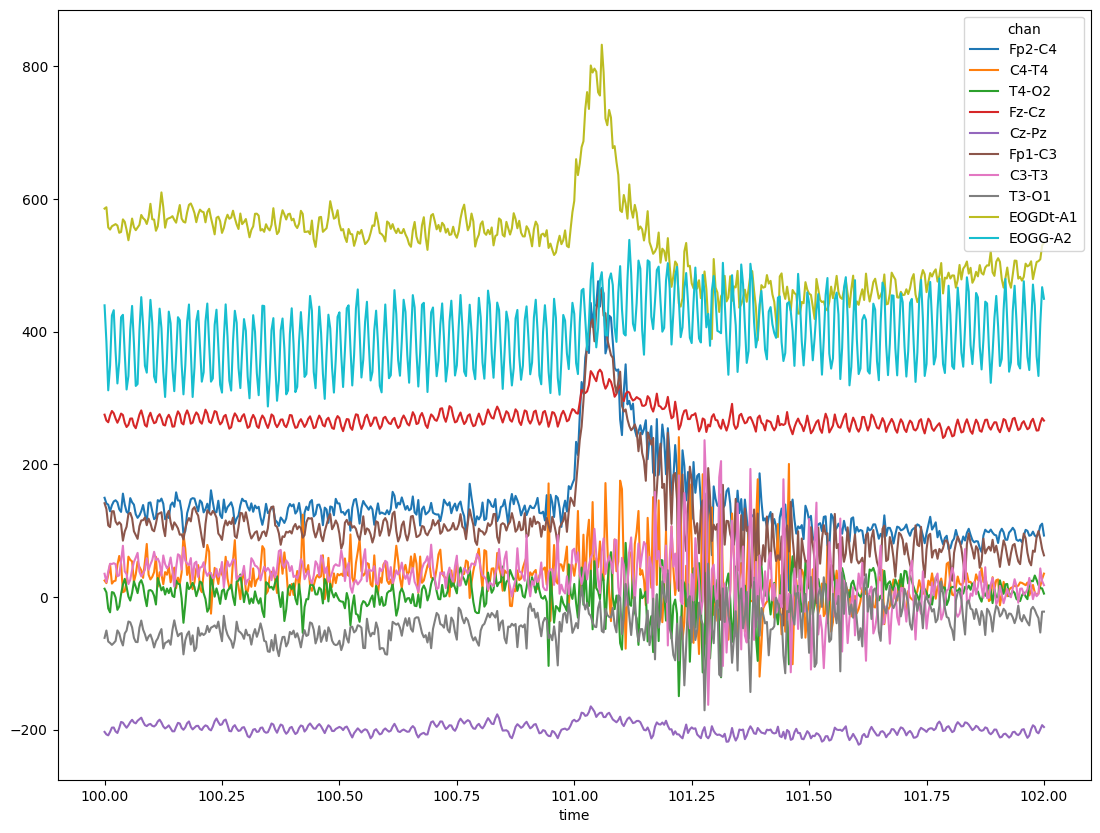

In [18]:
da_bipol.loc[:,100:102].plot.line(x='time', size = 10)

<Figure size 640x480 with 0 Axes>

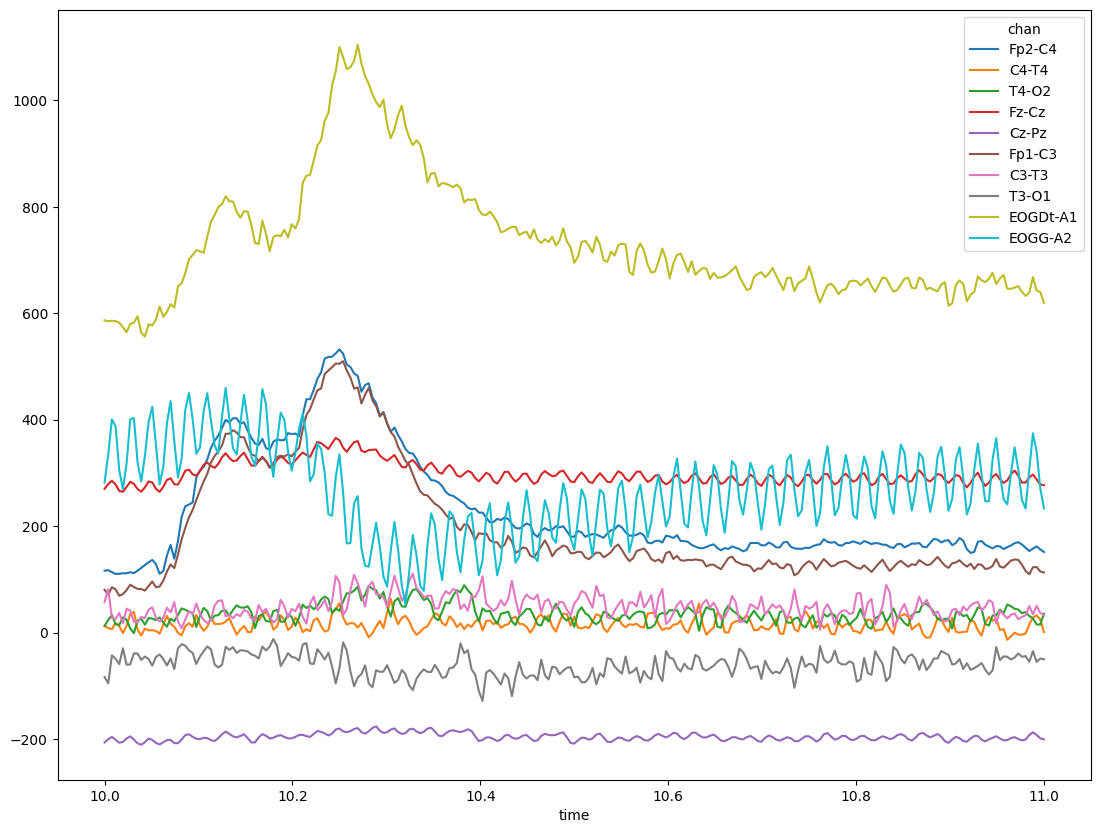

In [19]:
plt.figure()
da_bipol.loc[:,10:11].plot.line(x='time', hue = 'chan', size = 10)

# plt.savefig(f'../presentation/raw_bipol_signals_{patient}')
plt.show()

In [20]:
raw_mne = da_to_mne_object(da_bipol, srate)

Creating RawArray with float64 data, n_channels=10, n_times=10077440
    Range : 0 ... 10077439 =      0.000 ... 39364.996 secs
Ready.


* psd

In [21]:
# plt.figure()
# for dérivation in dérivations:
#     f, Pxx = gt.spectre(da_bipol.sel(chan = dérivation).values, srate=srate, wsize = 50)
#     plt.plot(f, Pxx, label = dérivation)
#     plt.legend()

# # plt.savefig(f'../presentation/psd_raw_bipol_{patient}')
# plt.show()

In [22]:
# plt.figure()
# for dérivation in dérivations:
#     f, Pxx = gt.spectre(da_bipol.sel(chan = dérivation).values, srate=srate, wsize = 50)
#     plt.plot(f[:1000], Pxx[:1000], label = dérivation)
#     plt.legend()
# plt.show()

* join bipol eeg to physios

In [23]:
da_physios = da.loc[physio_chans,:]

In [24]:
da_all = xr.concat([da_bipol , da_physios], dim = 'chan')

In [25]:
da_all_notched = to_notch_da(da_all, fs=srate)

KeyboardInterrupt: 

In [ ]:
# plt.figure()
# for dérivation in dérivations:
#     f, Pxx = gt.spectre(da_all_notched.sel(chan = dérivation).values, srate=srate, wsize = 50)
#     plt.plot(f, Pxx, label = dérivation)
#     plt.legend()

# # plt.savefig(f'../presentation/psd_post_notch_{patient}')
# plt.show()

In [ ]:
# plt.figure()
# for dérivation in dérivations:
#     f, Pxx = gt.spectre(da_all_notched.sel(chan = dérivation).values, srate=srate, wsize = 50)
#     plt.plot(f, Pxx, label = dérivation)
#     plt.xlim(0,1)
#     plt.legend()

# plt.show()

In [ ]:
eeg_names = [ chan for chan in dérivations if not chan in ['EOGDt-A1','EOGG-A2']]
eeg_names

## **READ ANNOTATIONS**

In [ ]:
txt_hypno_path = glob.glob(f'../data/{patient}/*hypnoEXP.txt')[0]
hypno = np.loadtxt(txt_hypno_path, dtype = str)
times = hypno[:,0]
epochs = hypno[:,2]

clean_epochs = []
double_epochs = []

clean_times = []
double_times = []

for time, epoch in zip(times, epochs):
    if not time in clean_times:
        if epoch == 'REM':
            epoch = 'R'
        clean_times.append(time)
        clean_epochs.append(epoch)
    else:
        double_times.append(time)
        double_epochs.append(epoch)

In [ ]:
pd.DataFrame(np.array([clean_times, clean_epochs]).T, columns = ['time','label'])

## **STAGING**

In [ ]:
def get_human_stages():
    txt_hypno_path = glob.glob(f'../data/{patient}/*hypnoEXP.txt')[0]
    hypno = np.loadtxt(txt_hypno_path, dtype = str)
    times = hypno[:,0]
    epochs = hypno[:,2]
    
    clean_epochs = []
    double_epochs = []
    
    clean_times = []
    double_times = []
    
    for time, epoch in zip(times, epochs):
        if not time in clean_times:
            if epoch == 'REM':
                epoch = 'R'
            clean_times.append(time)
            clean_epochs.append(epoch)
        else:
            double_times.append(time)
            double_epochs.append(epoch)
            
    return pd.Series(clean_epochs, name = 'human')

In [ ]:
def get_arousals(patient=patient):

    def get_epoch_of_arousal_time(arousal):
        h = int(arousal.split('h')[0])
        m = int(arousal.split('m')[0][-2:])
        s = int(arousal.split('m')[1][:2])
        return (h*3600 + m*60 + s) // 30

    annot_path = glob.glob(f'../data/{patient}/*Annotation*')[0]
    with open(annot_path, encoding="utf8", errors='ignore') as fichier:
        contenu = fichier.read()
    rows = contenu.split('\n')
    concat = []
    for row in rows:
        concat.append(row.split('\t'))
    df_txt = pd.DataFrame(concat)
    arousals = []
    for i in range(df_txt.shape[0]):
        if 'Arousal' in str(df_txt.loc[i,6]):
            arousals.append(df_txt.loc[i,2])

    arousals = pd.Series([get_epoch_of_arousal_time(arousal) for arousal in arousals])
    n_arousals = arousals.shape[0]
    arousal_epochs = arousals.unique()
    return n_arousals

In [ ]:
def get_yasa_stages(da_all_notched):
    raw = da_to_mne_object(da_all_notched, srate=srate)
    sls = yasa.SleepStaging(raw , eeg_name = 'C4-T4' , eog_name = 'EOGG-A2', emg_name='Menton')
    y_pred = sls.predict()
    return pd.Series(y_pred, name = 'ia')

In [ ]:
def is_arousal(i, epochs):
    if i in epochs:
        return 1
    else:
        return 0

In [ ]:
def get_staging(da_all_notched, patient = patient):
    ia_staging = get_yasa_stages(da_all_notched)
    human_staging = get_human_stages()
    if patient == 'P2':
        ia_staging = ia_staging[:-1] # P2 seems to have a problem with human staging other than doubling
    if ia_staging.shape[0] == human_staging.shape[0]:
        staging = pd.concat([ia_staging , human_staging], axis = 1)
    else:
        raise ValueError('different number of epochs between human vs ia staging')

    mapper = {'W':4,'N1':2,'N2':1,'N3':0,'R':3}
    human_digit = staging['human'].map(mapper)
    ia_digit = staging['ia'].map(mapper)
    staging['ia digit'] = ia_digit
    staging['human digit'] = human_digit
    return staging
        

In [ ]:
staging = get_staging(da_all_notched)

In [ ]:
# get summary staging perso
human_stage_raw = staging['human'].value_counts(normalize = False).reindex(['W','R','N1','N2','N3']).rename('human raw')
human_stage_propotion = staging['human'].value_counts(normalize = True).reindex(['W','R','N1','N2','N3'])
human_stage_propotion_mins = (human_stage_propotion * duration / 60).rename('human min')

yasa_stages_raw = staging['ia'].value_counts(normalize = False).reindex(['W','R','N1','N2','N3']).rename('ia raw')
yasa_stages_propotion = staging['ia'].value_counts(normalize = True).reindex(['W','R','N1','N2','N3'])
yasa_stages_propotion_mins = (yasa_stages_propotion * duration / 60).rename('IA min')

ratio_staging = (yasa_stages_propotion / human_stage_propotion).rename('ratio')
diff_ratio = (human_stage_propotion - yasa_stages_propotion).rename('diff ratio')

concat = [human_stage_raw,yasa_stages_raw, yasa_stages_propotion,human_stage_propotion,yasa_stages_propotion_mins,human_stage_propotion_mins, ratio_staging,diff_ratio] 
summary_staging_proportion = pd.concat(concat, axis = 1).T
summary_staging_proportion['recording time (min)'] = duration / 60
summary_staging_proportion['participant'] = patient

if save_df:
    summary_staging_proportion.to_excel(f'../participant_characteristics/stage_params_perso_{patient}.xlsx')

In [ ]:
time_in_bed = duration / 60

def get_sleep_onset_latency(assessor, staging=staging):
    return (staging[staging[assessor] != 'W'][assessor].index[0] + 1) * 30 / 60

def get_total_sleep_period(assessor, staging=staging):
    return time_in_bed - get_sleep_onset_latency(assessor, staging)

def get_wake_after_sleep_onset(assessor, staging=staging):
    mask = (staging.index > staging[staging[assessor] != 'W'][assessor].index[0]) & (staging.index < staging[staging[assessor] != 'W'][assessor].index[-1]) 
    return staging[mask][assessor].value_counts()['W'] * 30 / 60   

def get_total_sleep_time(assessor, staging=staging):
    return sum(staging[assessor] != 'W') * 30 / 60

def get_sleep_efficiency(assessor, staging=staging):
    return get_total_sleep_time(assessor,staging) / time_in_bed

def get_rem_latency(assessor, staging=staging):
    first_rem_epoch = staging[staging['human'] == 'R'].index[0] * 30 / 60
    return first_rem_epoch - get_sleep_onset_latency(assessor, staging=staging)

def get_stage_duration(stage, assessor ,staging=staging):
    return sum(staging[assessor] == stage) * 30 / 60

def get_percent_stage_duration(stage, assessor ,staging=staging):
    return get_stage_duration(stage, assessor,staging) / get_total_sleep_time(assessor, staging)

def get_arousal_index(assessor, staging=staging):
    return get_arousals() / (get_total_sleep_time(assessor,staging) / 60)

In [ ]:
rows = []
for assessor in ['human','ia']:
    time_in_bed = time_in_bed
    sleep_onset_latency = get_sleep_onset_latency(assessor)
    total_sleep_period = get_total_sleep_period(assessor)
    wake_after_sleep_onset = get_wake_after_sleep_onset(assessor)
    total_sleep_time = get_total_sleep_time(assessor)
    sleep_efficiency = get_sleep_efficiency(assessor)
    rem_latency = get_rem_latency(assessor)
    N2_raw_time = get_stage_duration('N2',assessor)
    N2_norm_time = N2_raw_time / total_sleep_time
    N3_raw_time = get_stage_duration('N3',assessor)
    N3_norm_time = N3_raw_time / total_sleep_time
    rem_raw_time = get_stage_duration('R',assessor)
    rem_norm_time = rem_raw_time / total_sleep_time
    arousal_index = get_arousal_index(assessor)

    row = [patient, assessor, time_in_bed, sleep_onset_latency, total_sleep_period, wake_after_sleep_onset, total_sleep_time, sleep_efficiency, rem_latency, N2_raw_time, N2_norm_time, N3_raw_time, N3_norm_time, rem_raw_time, rem_norm_time, arousal_index]
    rows.append(row)
colnames = ['participant', 'method','time in bed','sleep onset latency','total sleep period','wake after sleep onset','total sleep time','sleep efficiency','rem latency', 'N2 raw time','N2 norm time','N3 raw time','N3 norm time','rem raw time','rem norm time','arousal index']

df_staging_characteristics = pd.DataFrame(rows, columns = colnames)

if save_df:
    df_staging_characteristics.to_excel(f'../participant_characteristics/sleep_parameters_{patient}.xlsx')
    

In [ ]:
df_staging_characteristics

In [ ]:
fig, axs = plt.subplots(nrows = 2, figsize = (15,10), constrained_layout = True)

for row, mode in enumerate(['human digit','ia digit']):
    if mode == 'human digit':
        title = 'Human staging'
    elif mode == 'ia digit':
        title = 'IA staging'

    ax = axs[row]
    ax.plot(staging[mode], color = 'black')
    ax.set_yticks([0, 1 , 2 , 3 , 4])
    ax.set_yticklabels(['N3','N2','N1','R','W'])
    ax.set_title(title)
    ax.set_ylabel('Stage')
    ax.set_xlabel('Epoch')

if save_df:
    plt.savefig(f'../participant_characteristics/hypnogram_{patient}', bbox_inches = 'tight')

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,5), constrained_layout = True)
ax = axs[0]
summary_staging_proportion.loc[['ia','human'],['W','R','N1','N2','N3']].plot.bar(ax=ax)
ax.set_title('Proportion time by stage')

ax = axs[1]
summary_staging_proportion.loc['diff ratio',['W','R','N1','N2','N3']].plot.bar(ax=ax)
ax.set_title('Difference human - ia time of proportion of time by stage')

## **SLICING ONLY N2 + N3 DATA**

In [ ]:
labelling_method = 'ia'
stages_selection = ['N2','N3']

In [ ]:
da_epoched = gt.init_da({'chan':da_all_notched.coords['chan'].values, 'epoch':staging.index, 'time':np.arange(0, 30, 1 / srate)})

In [ ]:
for epoch in staging.index:
    start = epoch * 30
    stop = start + 30
    epoch_slice = da_all_notched.loc[:,start:stop].values[:,:-1]
    da_epoched.loc[:, epoch, :] = epoch_slice

In [ ]:
da_sliced = da_epoched.sel(epoch = staging[staging['ia'].isin(stages_selection)].index) # keep only epochs N2 and N3

In [ ]:
def stack_epochs(da, srate = srate):
    epochs = list(da.coords['epoch'].values)
    to_concat = []
    for epoch in epochs:
        da_epoch = da.sel(epoch = epoch).reset_coords(drop=True)
        to_concat.append(da_epoch)
    da_concat = xr.concat(to_concat, dim = 'time')
    time_vector = np.arange(0,da_concat.shape[1]/srate, 1/srate)
    da_return = da_concat.assign_coords({'time':time_vector}) 
    return da_return

In [ ]:
da_N2N3 = stack_epochs(da_sliced)

## **SAVING DATA**

In [ ]:
if save_da:
    da_N2N3.sel(chan = sel_chans).to_netcdf(f'../dataarray/da_N2N3_{patient}.nc')

## **SUMMARIZING DATA**

In [ ]:
metadata

In [ ]:
summary_staging_proportion.round(2)

In [ ]:
df_staging_characteristics.round(2)